In [956]:
%load_ext autoreload
%autoreload 2

import crispr_shrinkage

2023-02-07 15:34:30,381 - crispr_shrinkage.framework.CrisprShrinkage - INFO - test
2023-02-07 15:34:30,381 - crispr_shrinkage.framework.CrisprShrinkage - INFO - test
2023-02-07 15:34:30,381 - crispr_shrinkage.framework.CrisprShrinkage - INFO - test
2023-02-07 15:34:30,381 - crispr_shrinkage.framework.CrisprShrinkage - INFO - test
2023-02-07 15:34:30,381 - crispr_shrinkage.framework.CrisprShrinkage - INFO - test
2023-02-07 15:34:30,381 - crispr_shrinkage.framework.CrisprShrinkage - INFO - test
2023-02-07 15:34:30,381 - crispr_shrinkage.framework.CrisprShrinkage - INFO - test
2023-02-07 15:34:30,381 - crispr_shrinkage.framework.CrisprShrinkage - INFO - test
2023-02-07 15:34:30,381 - crispr_shrinkage.framework.CrisprShrinkage - INFO - test
2023-02-07 15:34:30,381 - crispr_shrinkage.framework.CrisprShrinkage - INFO - test
2023-02-07 15:34:30,381 - crispr_shrinkage.framework.CrisprShrinkage - INFO - test
2023-02-07 15:34:30,381 - crispr_shrinkage.framework.CrisprShrinkage - INFO - test
2023

In [957]:
from scipy.stats import binom
from scipy.stats import uniform
from scipy.stats import expon
import numpy as np 

null_proportion = 0.5
positive_proportion = 0.6
target_null_proportion = 0.5
target_positive_population = 0.6

num_ctrl_guides = 50
num_pos_guides = 10

reps = 3
max_dup_factor = 20
max_guide_molecule_factor = 200

pop1_dup_factor_list = np.asarray([np.round(uniform.rvs(1, max_dup_factor)) for _ in range(reps)])
pop2_dup_factor_list = np.asarray([np.round(uniform.rvs(1, max_dup_factor)) for _ in range(reps)])

#expon.rvs(loc=1, scale=1000, size=num_guides)
#uniform.rvs(2, 200, size=num_guides)
def get_counts(num_guides, proportion):
    pop1_list_reps = []
    pop2_list_reps = []

    for rep_i in range(reps):
        n_list = np.round(uniform.rvs(2, max_guide_molecule_factor, size=num_guides)).astype(int)
        pop1_list = binom.rvs(n_list, proportion, size=num_guides) 
        pop2_list = n_list - pop1_list

        pop1_list_reps.append(pop1_list * pop1_dup_factor_list[rep_i])
        pop2_list_reps.append(pop2_list * pop2_dup_factor_list[rep_i])
    
    return np.asarray(pop1_list_reps), np.asarray(pop2_list_reps)


In [958]:
tiling_length = 100

observation_guides = []
for position in range(tiling_length):
    counts = get_counts(1, target_null_proportion)
    pop1_raw_count_reps = counts[0].transpose()[0] + 1
    pop2_raw_count_reps = counts[1].transpose()[0] + 1
    guide = crispr_shrinkage.Guide(identifier="observation_{}".format(position), position=position, pop1_raw_count_reps= pop1_raw_count_reps, pop2_raw_count_reps=pop2_raw_count_reps)

    observation_guides.append(guide)

observation_guides = np.asarray(observation_guides)

In [959]:
negative_guides = []
for i in range(num_ctrl_guides):
    counts = get_counts(1, null_proportion)
    pop1_raw_count_reps = counts[0].transpose()[0] + 1
    pop2_raw_count_reps = counts[1].transpose()[0] + 1
    guide = crispr_shrinkage.Guide(identifier="negative_{}".format(i), position=None, pop1_raw_count_reps= pop1_raw_count_reps, pop2_raw_count_reps=pop2_raw_count_reps)

    negative_guides.append(guide)

negative_guides = np.asarray(negative_guides)

In [960]:
positive_guides = []
for i in range(num_pos_guides):
    counts = get_counts(1, positive_proportion)
    pop1_raw_count_reps = counts[0].transpose()[0] + 1
    pop2_raw_count_reps = counts[1].transpose()[0] + 1
    guide = crispr_shrinkage.Guide(identifier="positive_{}".format(i), position=None, pop1_raw_count_reps= pop1_raw_count_reps, pop2_raw_count_reps=pop2_raw_count_reps)

    positive_guides.append(guide)

positive_guides = np.asarray(positive_guides)

In [961]:
 from decimal import *
 getcontext().prec = 100
 Decimal(100)

Decimal('100')

In [962]:
sc.beta(10,1)

0.1

In [963]:
def precise_gamma(num) -> Decimal:
    return np.exp(Decimal(sc.gammaln(num)))

In [964]:
def precise_beta(a, b):
    return (precise_gamma(a)*precise_gamma(b))/(precise_gamma(a+b))

In [965]:
sc.beta(537, 537)/sc.beta(10, 10)

0.0

In [966]:
float(precise_beta(537, 537)/precise_beta(10, 10))

6.98347e-319

In [1032]:
import scipy
import functools
nc_high = 1200
nc_low = 1300
k_h = 13
k_l = 8

def KL_optim(test, params):
    nc_weight, k_weight = params 
    print(params)
    return crispr_shrinkage.StatisticalHelperMethods.KL_beta(31.0, 26.0, (nc_weight*nc_high) + (k_weight * k_h), (nc_weight*nc_low) + (k_weight * k_l))

res = scipy.optimize.minimize(functools.partial(KL_optim, "1"), [1, 1], method = 'TNC', bounds=((0, np.inf),(0, np.inf)))

In [1031]:
res

 message: Converged (|f_n-f_(n-1)| ~= 0)
 success: True
  status: 1
     fun: 2.4425003361007447e-11
       x: [ 1.233e-02  1.247e+00]
     nit: 8
     jac: [ 1.099e-06 -4.764e-07]
    nfev: 96

In [1023]:
KL_optim(res.x)

[0.01232871 1.24656011]


2.4425003361007447e-11

In [976]:
crispr_shrinkage.StatisticalHelperMethods.KL_beta(31.0, 26.0, 24, 36)

2.53971408061148

In [971]:
alpha_f, beta_f, alpha_g, beta_g = (31.0, 26.076923076923077, 310, 260)

In [972]:
Decimal.ln(crispr_shrinkage.StatisticalHelperMethods.precise_beta(alpha_g, beta_g)/(crispr_shrinkage.StatisticalHelperMethods.precise_beta(alpha_f, beta_f)))

Decimal('-354.7024313268700765888752357568591833114624023437500000000000000000000000000000000000000000000000000')

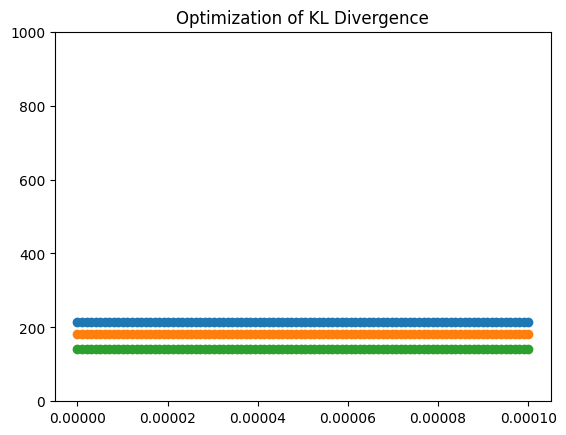

2023-02-07 15:35:09,612 - crispr_shrinkage.framework.CrisprShrinkage - INFO - Selected imputation prior weights: [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
2023-02-07 15:35:09,612 - crispr_shrinkage.framework.CrisprShrinkage - INFO - Selected imputation prior weights: [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
2023-02-07 15:35:09,612 - crispr_shrinkage.framework.CrisprShrinkage - INFO - Selected imputation prior weights: [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
2023-02-07 15:35:09,612 - crispr_shrinkage.framework.CrisprShrinkage - INFO - Selected imputation prior weights: [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
2023-02-07 15:35:09,612 - crispr_shrinkage.framework.CrisprShrinkage - INFO - Selected imputation prior weights: [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
2023-02-07 15:35:09,612 - crispr_shrinkage.framework.CrisprShrinkage - INFO - Selected imputation prior weights: [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
2023-02-07 15:35:09,612 - crispr_shrinkage.framework.CrisprShrinkage - INFO - Selected imputation pr

ValueError: Domain error in arguments. The `scale` parameter must be positive for all distributions, and many distributions have restrictions on shape parameters. Please see the `scipy.stats.beta` documentation for details.

In [970]:
crispr_shrinkage.perform_adjustment(
    negative_control_guides = negative_guides,
    positive_control_guides = positive_guides,
    observation_guides = observation_guides,
    num_replicates = reps,
    include_observational_guides_in_fit = True,
    include_positive_control_guides_in_fit = False,
    pop1_amplification_factors = pop1_dup_factor_list,
    pop2_amplification_factors = pop2_dup_factor_list,
    monte_carlo_trials = 1000,
    enable_spatial_prior =  True,
    spatial_bandwidth = 3,
    spatial_imputation_prior_strength = None, # This could be optimized by maximizing correlation of guide with neighborhood (perhaps in binomial GLM fashion?),
    baseline_proportion = 0.5, # TODO: Perform validation between (0,1), also accept None value for perfrming no normalization (or have that be another argument)
    shrinkage_prior_strength = None, 
    posterior_estimator = "mean",
    random_seed = 234
    )

In [ ]:
on_factors = pop1_dup_factor_list,
    pop2_amplification_factors = pop2_dup_factor_list,
    monte_carlo_trials = 1000,
    enable_spatial_prior =  True,
    spatial_bandwidth = 1,
    spatial_imputation_prior_strength = None, # This could be optimized by maximizing correlation of guide with neighborhood (perhaps in binomial GLM fashion?),
    baseline_proportion = 0.5, # TODO: Perform validation between (0,1), also accept None value for perfrming no normalization (or have that be another argument)
    shrinkage_prior_strength = None, 
    posterior_estimator = "mean",
    random_seed = 234
    )

In [ ]:
pop1_dup_factor_list is None

In [ ]:
crispr_shrinkage.Guide